In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split
from PIL import ImageEnhance



# Import Cleaned DF

In [3]:
filtered_df = pd.read_csv('../../csv/cleaned_csv_19_class.csv')
filtered_df.head()

,file_name,variety,layout_id,packed,amount,weight,crowd,subset,simp_amount,uniform_background,spoiled,rank,adjusted_weight,label
0,007576.jpg,apple_fuji,1246,1,5,776.0,0,train,4-6,0,0,1,776.0,6
1,085095.jpg,apple_fuji,1246,1,5,776.0,0,train,4-6,0,0,2,776.0,6
2,077142.jpg,apple_fuji,1246,1,5,776.0,0,train,4-6,0,0,3,776.0,6
3,091219.jpg,apple_fuji,1246,1,5,776.0,0,train,4-6,0,0,4,776.0,6
4,019846.jpg,apple_fuji,4610,1,5,776.0,1,test,4-6,0,0,1,776.0,6


In [ ]:
filtered_df['file_path'] = filtered_df.apply(
    lambda row: os.path.join('..', row['subset'], f"resized_images_{row['subset']}", f"{row['subset']}_{row['variety']}", row['file_name']),
    axis=1
)

# Reduce Sample Size

In [4]:
filtered_df_train = filtered_df[filtered_df['subset'] == 'train']
filtered_df_test = filtered_df[filtered_df['subset'] == 'test']

## TRAIN

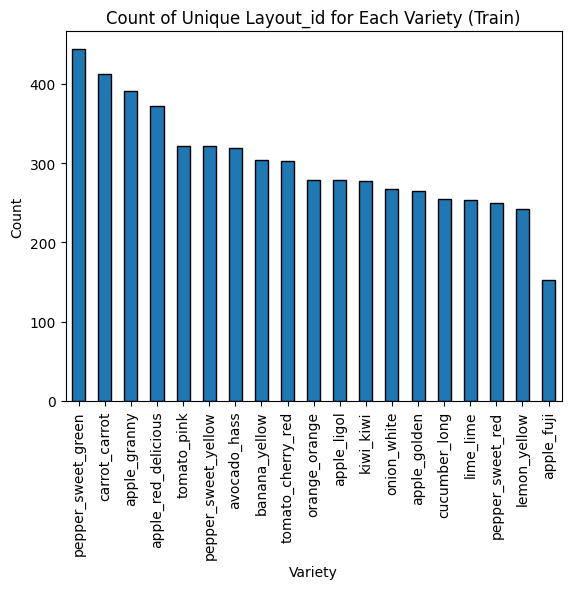

In [5]:
# Group by 'variety' and get the count of unique 'layout_id' for each variety

filtered_df_train_unique = filtered_df_train.drop_duplicates(subset=['variety', 'layout_id'], keep='first')

filtered_df_train_grouped = filtered_df_train_unique.groupby(['variety']).size()

# Sort the grouped data by count in descending order
filtered_df_train_grouped_sorted = filtered_df_train_grouped.sort_values(ascending=False)

# Plot the sorted values
filtered_df_train_grouped_sorted.plot(kind='bar', edgecolor='black')

# Display the plot
plt.title('Count of Unique Layout_id for Each Variety (Train)')
plt.xlabel('Variety')
plt.ylabel('Count')
plt.show()

In [6]:
# Filter out varieties with more than 300 unique 'layout_id'
varieties_to_reduce = filtered_df_train_grouped[filtered_df_train_grouped > 300].index

print(varieties_to_reduce)

reduced_data = pd.DataFrame()

from sklearn.model_selection import train_test_split

for variety in varieties_to_reduce:
    # Get the rows corresponding to the current variety
    to_reduce = filtered_df_train_unique[filtered_df_train_unique['variety'] == variety]
    
    # Ensure we don't sample more rows than exist
    sample_size = min(300, len(to_reduce))  # If the variety has fewer than 300 rows, sample all
    
    # Perform stratified sampling to preserve the distribution of 'amount'
    try:
        train_300, _ = train_test_split(to_reduce, 
                                        train_size=sample_size, 
                                        stratify=to_reduce['amount'],  # Stratify by the 'amount' column
                                        random_state=42)
    except ValueError:
        # If there are not enough classes in 'amount' to stratify, fall back to simple random sampling
        print(f"Not enough classes in 'amount' to stratify for variety: {variety}. Performing random sampling.")
        train_300, _ = train_test_split(to_reduce, 
                                        train_size=sample_size, 
                                        random_state=42)

    # Append the reduced data to the reduced_data DataFrame
    reduced_data = pd.concat([reduced_data, train_300], axis=0)

Index(['apple_granny', 'apple_red_delicious', 'avocado_hass', 'banana_yellow',
       'carrot_carrot', 'pepper_sweet_green', 'pepper_sweet_yellow',
       'tomato_cherry_red', 'tomato_pink'],
      dtype='object', name='variety')
Not enough classes in 'amount' to stratify for variety: banana_yellow. Performing random sampling.
Not enough classes in 'amount' to stratify for variety: tomato_cherry_red. Performing random sampling.


In [7]:
print('filtered_df_train:', filtered_df_train.shape)

filtered_train_toreduce = filtered_df_train[filtered_df_train['variety'].isin(varieties_to_reduce)]
print('filtered_train_notreduced:', filtered_train_toreduce.shape)

filtered_train_reduced = filtered_df_train[filtered_df_train['layout_id'].isin(reduced_data['layout_id'].unique())]
print('filtered_train_reduced:', filtered_train_reduced.shape)

filtered_train_notreduced = filtered_df_train[~filtered_df_train['variety'].isin(varieties_to_reduce)]
print('filtered_train_notreduced:', filtered_train_notreduced.shape)

filtered_df_train_filtered = pd.concat([filtered_train_notreduced,filtered_train_reduced])
print('filtered_df_train_filtered:', filtered_df_train_filtered.shape)

filtered_df_train: (22832, 14)
filtered_train_notreduced: (12748, 14)
filtered_train_reduced: (10800, 14)
filtered_train_notreduced: (10084, 14)
filtered_df_train_filtered: (20884, 14)


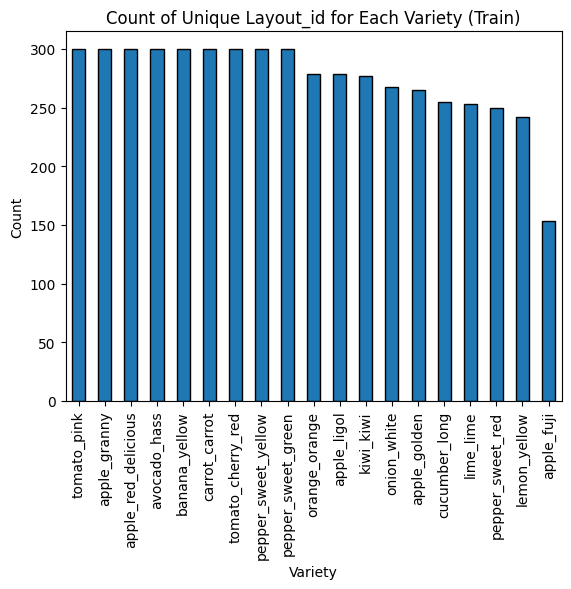

In [8]:
# Group by 'variety' and get the count of unique 'layout_id' for each variety

filtered_df_train_unique = filtered_df_train_filtered.drop_duplicates(subset=['variety', 'layout_id'], keep='first')

filtered_df_train_grouped = filtered_df_train_unique.groupby(['variety']).size()

# Sort the grouped data by count in descending order
filtered_df_train_grouped_sorted = filtered_df_train_grouped.sort_values(ascending=False)

# Plot the sorted values
filtered_df_train_grouped_sorted.plot(kind='bar', edgecolor='black')

# Display the plot
plt.title('Count of Unique Layout_id for Each Variety (Train)')
plt.xlabel('Variety')
plt.ylabel('Count')
plt.show()

In [9]:
df_train = filtered_df_train_filtered.copy()

### Resize Images to 224x224

In [ ]:
#Resize the images in Train

import zipfile
import shutil
from PIL import Image


train_zip_path = '../train'

zip_files = [f for f in os.listdir(train_zip_path) if f.endswith('.zip')]

for i in range(len(zip_files)):
    zip_file_path = os.path.join(train_zip_path, zip_files[i])
    print("Extracting", zip_files[i])
    # Temporary directory where the zip file will be extracted
    temporary_direct = f'train/temporary_zip/temp_folder_{zip_files[i].split(".")[0]}'

    # Create the temp directory if it doesn't exist
    os.makedirs(temporary_direct, exist_ok=True) 

    print('Temporary directory for', zip_files[i], 'created.')

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temporary_direct)

    print('zip file extracted to:', temporary_direct)

    ##### RESIZING

    # Path to the folder containing files
    folder_path = temporary_direct

    # Path to save resized images
    output_folder = f'../train/resized_images_train/{zip_files[i].split(".")[0]}'

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Convert the 'file_name' column to a set of matching filenames
    matching_filenames = set(df_train['file_name'])

    # Resize dimensions for CNN (e.g., 224x224)
    resize_dim = (224, 224)

    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        if filename in matching_filenames:
            # Full path of the image
            file_path = os.path.join(folder_path, filename)

            try:
                # Open the image
                with Image.open(file_path) as img:
                    # Resize the image
                    img_resized = img.resize(resize_dim, Image.LANCZOS) #LANCZOS recommended for high-quality downscaling
                    
                    # Save the resized image to the output folder
                    output_path = os.path.join(output_folder, filename)
                    img_resized.save(output_path)
                    #print(f"Resized and saved: {filename}")
            except Exception as e:
                print(f"ERROR ¨PROCESSING {filename}: {e}")

    # Remove the temporary folder and its contents after processing
    shutil.rmtree(temporary_direct)

### Data Augmentation

In [ ]:
random_datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=True  # Random vertical flip
)

In [12]:
df_train.head(2)

,file_name,variety,layout_id,packed,amount,weight,crowd,subset,simp_amount,uniform_background,spoiled,rank,adjusted_weight,label,file_path
0,007576.jpg,apple_fuji,1246,1,5,776.0,0,train,4-6,0,0,1,776.0,6,../train/resized_images_train/train_apple_fuji...
1,085095.jpg,apple_fuji,1246,1,5,776.0,0,train,4-6,0,0,2,776.0,6,../train/resized_images_train/train_apple_fuji...


In [55]:
train_rank1 = df_train[df_train['rank'] == 1]
train_rank234 = df_train[df_train['rank'].isin([2,3,4])]

In [ ]:
for variety in list(df_train['variety'].unique()):

    variety_data = train_rank234[train_rank234['variety'] == variety].reset_index(drop=True)
    
    image_paths = [path for path in variety_data['file_path']]
    image_data = np.array([img_to_array(load_img(img)) for img in image_paths])
    
    save_dir = f'../train/augmented_images_train/{variety}/'
    os.makedirs(save_dir, exist_ok=True)
    
    # Create an augmentation generator
    augmented_images = random_datagen.flow(image_data, batch_size=1, shuffle=False)  # Ensure images are processed in order

    #Apply brightness

    for i, augmented_image_batch in enumerate(augmented_images):
        if i == len(image_data):  # Stop when all images have been processed
            break
        augmented_image = augmented_image_batch[0]
        #Convert array to image
        pil_image = array_to_img(augmented_image, scale=False)
        #Introduce a brightness factor, we care about more brightness (usually supermarket case)
        brightness_factor = np.random.uniform(0.8, 1.5)
        # Apply brightness enhancement using ImageEnhance
        enhancer = ImageEnhance.Brightness(pil_image)
        enhanced_im = enhancer.enhance(brightness_factor)
        # Apply random sharpness enhancement
        sharpness_factor = np.random.uniform(0.8, 1.5)  # Random sharpness factor
        sharpness_enhancer = ImageEnhance.Sharpness(enhanced_im)  # Sharpness enhancer
        final_im = sharpness_enhancer.enhance(sharpness_factor)   

        augmented_image_filename = variety_data['file_name'].iloc[i]
        augmented_image_path = os.path.join(save_dir, augmented_image_filename)

        # Save the image in JPEG format
        enhanced_im.save(augmented_image_path, format='JPEG')
        
    print(f"Saved augmented images to {save_dir}")

In [ ]:
# Move the non-augmented files to the same folder

for variety in train_rank1['variety'].unique():
    # Filter df_train_not_augmentation by the current variety
    variety_data = train_rank1[train_rank1['variety'] == variety]

    # Iterate over the file paths in this filtered DataFrame
    for _, row in variety_data.iterrows():
        # Get the file path from the DataFrame
        file_path = row['file_path']

        # Define the target folder where you want to move the files
        target_folder = f'../train/augmented_images_train/{variety}/'

        # Make sure the target folder exists
        os.makedirs(target_folder, exist_ok=True)

        # Extract the file name from the file path
        file_name = os.path.basename(file_path)

        # Define the target file path
        target_file_path = os.path.join(target_folder, file_name)

        # Move the file to the target folder
        shutil.move(file_path, target_file_path)

        print(f"Moved {file_name} to {target_folder}")   

Moved 019846.jpg to ../test/augmented_images_test/apple_fuji/
Moved 019604.jpg to ../test/augmented_images_test/apple_fuji/
Moved 091917.jpg to ../test/augmented_images_test/apple_fuji/
Moved 050829.jpg to ../test/augmented_images_test/apple_fuji/
Moved 010514.jpg to ../test/augmented_images_test/apple_fuji/
Moved 028794.jpg to ../test/augmented_images_test/apple_fuji/
Moved 029122.jpg to ../test/augmented_images_test/apple_fuji/
Moved 002417.jpg to ../test/augmented_images_test/apple_fuji/
Moved 048985.jpg to ../test/augmented_images_test/apple_fuji/
Moved 005326.jpg to ../test/augmented_images_test/apple_fuji/
Moved 021105.jpg to ../test/augmented_images_test/apple_fuji/
Moved 076711.jpg to ../test/augmented_images_test/apple_fuji/
Moved 039127.jpg to ../test/augmented_images_test/apple_fuji/
Moved 097145.jpg to ../test/augmented_images_test/apple_fuji/
Moved 075020.jpg to ../test/augmented_images_test/apple_fuji/
Moved 070858.jpg to ../test/augmented_images_test/apple_fuji/
Moved 01

In [ ]:
#Delete the resized folder

folder_path = '../train/resized_images_train'

shutil.rmtree(folder_path)

# TEST

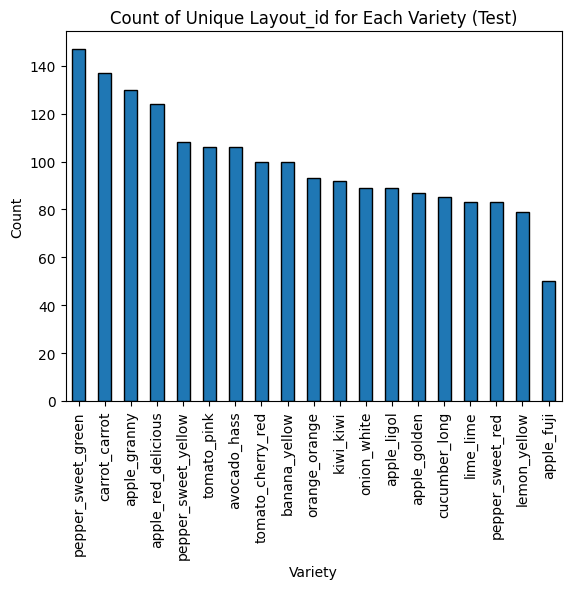

In [13]:
# Group by 'variety' and get the count of unique 'layout_id' for each variety

filtered_df_test_unique = filtered_df_test.drop_duplicates(subset=['variety', 'layout_id'], keep='first')

filtered_df_test_grouped = filtered_df_test_unique.groupby(['variety']).size()

# Sort the grouped data by count in descending order
filtered_df_test_grouped_sorted = filtered_df_test_grouped.sort_values(ascending=False)

# Plot the sorted values
filtered_df_test_grouped_sorted.plot(kind='bar', edgecolor='black')

# Display the plot
plt.title('Count of Unique Layout_id for Each Variety (Test)')
plt.xlabel('Variety')
plt.ylabel('Count')
plt.show()

In [14]:
# Filter out varieties with more than 100 unique 'layout_id'

varieties_to_reduce = filtered_df_test_grouped[filtered_df_test_grouped > 100].index

print(varieties_to_reduce)

reduced_data = pd.DataFrame()

from sklearn.model_selection import train_test_split

for variety in varieties_to_reduce:
    # Get the rows corresponding to the current variety
    to_reduce = filtered_df_test_unique[filtered_df_test_unique['variety'] == variety]
    
    # Ensure we don't sample more rows than exist
    sample_size = min(100, len(to_reduce))  # If the variety has fewer than 100 rows, sample all
    
    # Perform stratified sampling to preserve the distribution of 'amount'
    try:
        test_100, _ = train_test_split(to_reduce, 
                                        train_size=sample_size, 
                                        stratify=to_reduce['amount'],  # Stratify by the 'amount' column
                                        random_state=42)
    except ValueError:
        # If there are not enough classes in 'amount' to stratify, fall back to simple random sampling
        print(f"Not enough classes in 'amount' to stratify for variety: {variety}. Performing random sampling.")
        test_100, _ = train_test_split(to_reduce, 
                                        train_size=sample_size, 
                                        random_state=42)

    # Append the reduced data to the reduced_data DataFrame
    reduced_data = pd.concat([reduced_data, test_100], axis=0)

Index(['apple_granny', 'apple_red_delicious', 'avocado_hass', 'carrot_carrot',
       'pepper_sweet_green', 'pepper_sweet_yellow', 'tomato_pink'],
      dtype='object', name='variety')
Not enough classes in 'amount' to stratify for variety: apple_granny. Performing random sampling.
Not enough classes in 'amount' to stratify for variety: avocado_hass. Performing random sampling.
Not enough classes in 'amount' to stratify for variety: pepper_sweet_yellow. Performing random sampling.
Not enough classes in 'amount' to stratify for variety: tomato_pink. Performing random sampling.


In [15]:
#Edit the DF to include only the layout_id from the reduced data for those varieties

print('filtered_df_test:', filtered_df_test.shape)

filtered_test_toreduce = filtered_df_test[filtered_df_test['variety'].isin(varieties_to_reduce)]
print('filtered_test_toreduce:', filtered_test_toreduce.shape)

filtered_test_reduced = filtered_df_test[filtered_df_test['layout_id'].isin(reduced_data['layout_id'].unique())]
print('filtered_test_reduced:', filtered_test_reduced.shape)

filtered_test_notreduced = filtered_df_test[~filtered_df_test['variety'].isin(varieties_to_reduce)]
print('filtered_test_notreduced:', filtered_test_notreduced.shape)

filtered_df_test_filtered = pd.concat([filtered_test_notreduced,filtered_test_reduced])
print('filtered_df_test_filtered:', filtered_df_test_filtered.shape)



filtered_df_test: (7552, 14)
filtered_test_toreduce: (3432, 14)
filtered_test_reduced: (2800, 14)
filtered_test_notreduced: (4120, 14)
filtered_df_test_filtered: (6920, 14)


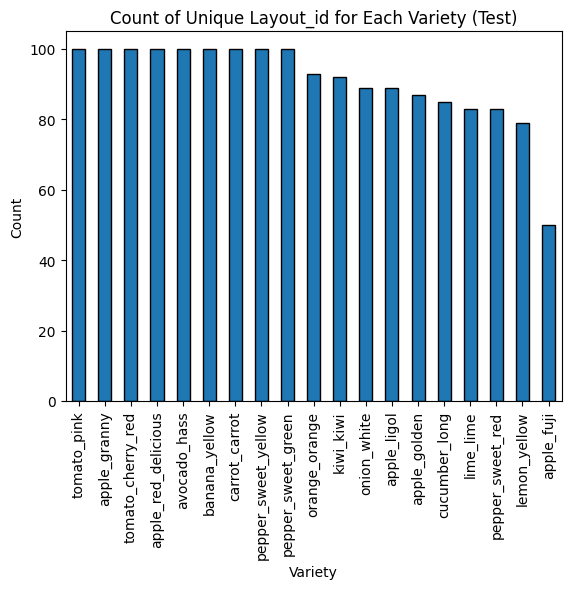

In [16]:
# Group by 'variety' and get the count of unique 'layout_id' for each variety

filtered_df_test_unique = filtered_df_test_filtered.drop_duplicates(subset=['variety', 'layout_id'], keep='first')

filtered_df_test_grouped = filtered_df_test_unique.groupby(['variety']).size()

# Sort the grouped data by count in descending order
filtered_df_test_grouped_sorted = filtered_df_test_grouped.sort_values(ascending=False)

# Plot the sorted values
filtered_df_test_grouped_sorted.plot(kind='bar', edgecolor='black')

# Display the plot
plt.title('Count of Unique Layout_id for Each Variety (Test)')
plt.xlabel('Variety')
plt.ylabel('Count')
plt.show()

In [17]:
df_test = filtered_df_test_filtered.copy()

### Resize Images to 224x224

In [ ]:
#Resize the images in Train

import zipfile
import shutil
from PIL import Image


test_zip_path = '../test'

zip_files = [f for f in os.listdir(test_zip_path) if f.endswith('.zip')]

for i in range(len(zip_files)):
    zip_file_path = os.path.join(test_zip_path, zip_files[i])
    print("Extracting", zip_files[i])
    # Temporary directory where the zip file will be extracted
    temporary_direct = f'test/temporary_zip/temp_folder_{zip_files[i].split(".")[0]}'

    # Create the temp directory if it doesn't exist
    os.makedirs(temporary_direct, exist_ok=True) 

    print('Temporary directory for', zip_files[i], 'created.')

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temporary_direct)

    print('zip file extracted to:', temporary_direct)

    ##### RESIZING

    # Path to the folder containing files
    folder_path = temporary_direct

    # Path to save resized images
    output_folder = f'../test/resized_images_test/{zip_files[i].split(".")[0]}'

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Convert the 'file_name' column to a set of matching filenames
    matching_filenames = set(df_test['file_name'])

    # Resize dimensions for CNN (e.g., 224x224)
    resize_dim = (224, 224)

    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        if filename in matching_filenames:
            # Full path of the image
            file_path = os.path.join(folder_path, filename)

            try:
                # Open the image
                with Image.open(file_path) as img:
                    # Resize the image
                    img_resized = img.resize(resize_dim, Image.LANCZOS) #LANCZOS recommended for high-quality downscaling
                    
                    # Save the resized image to the output folder
                    output_path = os.path.join(output_folder, filename)
                    img_resized.save(output_path)
                    #print(f"Resized and saved: {filename}")
            except Exception as e:
                print(f"ERROR ¨PROCESSING {filename}: {e}")

    # Remove the temporary folder and its contents after processing
    shutil.rmtree(temporary_direct)


Extracting test_lime_lime.zip
Temporary directory for test_lime_lime.zip created.
zip file extracted to: test/temporary_zip/temp_folder_test_lime_lime
Extracting test_onion_white.zip
Temporary directory for test_onion_white.zip created.
zip file extracted to: test/temporary_zip/temp_folder_test_onion_white
Extracting test_apple_red_delicious.zip
Temporary directory for test_apple_red_delicious.zip created.
zip file extracted to: test/temporary_zip/temp_folder_test_apple_red_delicious
Extracting test_avocado_hass.zip
Temporary directory for test_avocado_hass.zip created.
zip file extracted to: test/temporary_zip/temp_folder_test_avocado_hass
Extracting test_apple_ligol.zip
Temporary directory for test_apple_ligol.zip created.
zip file extracted to: test/temporary_zip/temp_folder_test_apple_ligol
Extracting test_pepper_sweet_red.zip
Temporary directory for test_pepper_sweet_red.zip created.
zip file extracted to: test/temporary_zip/temp_folder_test_pepper_sweet_red
Extracting test_cucumb

### Data Augmentation

In [37]:
random_datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=True  # Random vertical flip
)

In [36]:
test_rank1 = df_test[df_test['rank'] == 1]
test_rank234 = df_test[df_test['rank'].isin([2,3,4])]

In [ ]:
for variety in list(df_test['variety'].unique()):

    variety_data = test_rank234[test_rank234['variety'] == variety].reset_index(drop=True)
    
    image_paths = [path for path in variety_data['file_path']]
    image_data = np.array([img_to_array(load_img(img)) for img in image_paths])
    
    save_dir = f'../test/augmented_images_test/{variety}/'
    os.makedirs(save_dir, exist_ok=True)
    
    # Create an augmentation generator
    augmented_images = random_datagen.flow(image_data, batch_size=1, shuffle=False)  # Ensure images are processed in order

    #Apply brightness

    for i, augmented_image_batch in enumerate(augmented_images):
        if i == len(image_data):  # Stop when all images have been processed
            break
        augmented_image = augmented_image_batch[0]
        #Convert array to image
        pil_image = array_to_img(augmented_image, scale=False)
        #Introduce a brightness factor, we care about more brightness (usually supermarket case)
        brightness_factor = np.random.uniform(0.8, 1.5)
        # Apply brightness enhancement using ImageEnhance
        enhancer = ImageEnhance.Brightness(pil_image)
        enhanced_im = enhancer.enhance(brightness_factor)
        # Apply random sharpness enhancement
        sharpness_factor = np.random.uniform(0.8, 1.5)  # Random sharpness factor
        sharpness_enhancer = ImageEnhance.Sharpness(enhanced_im)  # Sharpness enhancer
        final_im = sharpness_enhancer.enhance(sharpness_factor)   

        augmented_image_filename = variety_data['file_name'].iloc[i]
        augmented_image_path = os.path.join(save_dir, augmented_image_filename)

        # Save the image in JPEG format
        enhanced_im.save(augmented_image_path, format='JPEG')
        
    print(f"Saved augmented images to {save_dir}")

In [43]:
# Move the non-augmented files to the same folder

for variety in test_rank1['variety'].unique():
    # Filter df_train_not_augmentation by the current variety
    variety_data = test_rank1[test_rank1['variety'] == variety]

    # Iterate over the file paths in this filtered DataFrame
    for _, row in variety_data.iterrows():
        # Get the file path from the DataFrame
        file_path = row['file_path']

        # Define the target folder where you want to move the files
        target_folder = f'../test/augmented_images_test/{variety}/'

        # Make sure the target folder exists
        os.makedirs(target_folder, exist_ok=True)

        # Extract the file name from the file path
        file_name = os.path.basename(file_path)

        # Define the target file path
        target_file_path = os.path.join(target_folder, file_name)

        # Move the file to the target folder
        shutil.move(file_path, target_file_path)

        print(f"Moved {file_name} to {target_folder}")   

Moved 019846.jpg to ../test/augmented_images_test/apple_fuji/
Moved 019604.jpg to ../test/augmented_images_test/apple_fuji/
Moved 091917.jpg to ../test/augmented_images_test/apple_fuji/
Moved 050829.jpg to ../test/augmented_images_test/apple_fuji/
Moved 010514.jpg to ../test/augmented_images_test/apple_fuji/
Moved 028794.jpg to ../test/augmented_images_test/apple_fuji/
Moved 029122.jpg to ../test/augmented_images_test/apple_fuji/
Moved 002417.jpg to ../test/augmented_images_test/apple_fuji/
Moved 048985.jpg to ../test/augmented_images_test/apple_fuji/
Moved 005326.jpg to ../test/augmented_images_test/apple_fuji/
Moved 021105.jpg to ../test/augmented_images_test/apple_fuji/
Moved 076711.jpg to ../test/augmented_images_test/apple_fuji/
Moved 039127.jpg to ../test/augmented_images_test/apple_fuji/
Moved 097145.jpg to ../test/augmented_images_test/apple_fuji/
Moved 075020.jpg to ../test/augmented_images_test/apple_fuji/
Moved 070858.jpg to ../test/augmented_images_test/apple_fuji/
Moved 01

In [44]:
#Delete the resized folder

folder_path = '../test/resized_images_test'

shutil.rmtree(folder_path)

## Create Validation Set

In [27]:
# Get unique layout IDs and associated labels
layout_df = df_train.groupby("layout_id")["label"].first().reset_index()

# Stratified split based on label distribution
train_layouts, val_layouts = train_test_split(
    layout_df["layout_id"], test_size=0.2, stratify=layout_df["label"], random_state=42
)

df_train.loc[df_train['layout_id'].isin(val_layouts), 'subset'] = 'validation'

train_samples = len(df_train[df_train['subset'] == 'train'])
val_samples = len(df_train[df_train['subset'] == 'validation'])
test_layouts = df_test['layout_id'].nunique()

print(f"✅ Train Layouts: {len(train_layouts)}, Validation Layouts: {len(val_layouts)}, 'Test Layouts: {test_layouts}")
print(f"✅ Training samples: {train_samples}, Validation samples: {val_samples}, Test samples: {len(df_test)}")


✅ Train Layouts: 4176, Validation Layouts: 1045, 'Test Layouts: 1730
✅ Training samples: 16704, Validation samples: 4180, Test samples: 6920


## Join  the DF

In [30]:
df_19_clean_filtered = pd.concat([df_train, df_test], axis=1, ignore_index=True)

df_19_clean_filtered.to_csv('../df_19_clean_filtered.csv', index=False)